<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/QuantumToyAlgorithm_Deutsch'sAlgorithm_01_OracleFunction_mkbahk_20250331.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 15.1 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=079b07df3a0c3b008b9c20f985e175a2af98f5d17af1768504595904e69a5ee8
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 12.8 MB/s eta 0:00:00
  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-lb6125op
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/qiski

In [2]:
%pip show qiskit
%pip show qiskit-aer

Name: qiskit
Version: 1.2.4
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-textbook
Name: qiskit-aer
Version: 0.15.1
Summary: Aer - High performance simulators for Qiskit
Home-page: https://github.com/Qiskit/qiskit-aer
Author: AER Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, psutil, qiskit, scipy
Required-by: 


In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex
from IPython.display import display, Math
import numpy as np
from qiskit.quantum_info import Statevector

In [4]:
# 상수 함수 오라클 (항상 0 반환)
def constant_oracle(q0, q1):
    qc = QuantumCircuit(2, name="Oracle Uf-Constant")
    return qc  # 아무런 연산도 하지 않음 (항상 0 반환)
###def

In [5]:
# 균형 함수 오라클 (NOT 게이트 적용하여 0과 1을 반반으로 만듦)
def balanced_oracle(q0, q1):
    #qc = QuantumCircuit(2, name="Oracle Uf-Balanced")
    qc = QuantumCircuit([q0, q1], name="Oracle Uf-Balanced")
    qc.cx(q0, q1)  # 입력 큐비트(q_0)에 따라 보조 큐비트(q_1) 상태 변경
    return qc
###def

In [44]:
qr = QuantumRegister(2)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)  # 2 qubits, 1 classical bit

# 초기 상태 설정
qc.x(1)  # 보조 큐비트 q_1을 |1> 상태로 설정
qc.barrier()
qc.h([0, 1])  # 두 큐비트에 아다마르 변환 적용
qc.barrier()

# 오라클 적용
# The balanced_oracle function needs to be called and its result appended
# oracle_circuit = balanced_oracle(qr[0], qr[1])  # Call the function to get the circuit
# qc.append(balanced_oracle, [qr[0], qr[1]]) # Append the oracle circuit to qc with the qubits

qc.append(constant_oracle(qr[0], qr[1]), [qr[0], qr[1]]) # Append the oracle circuit to qc with the qubits

#qc.append(balanced_oracle(qr[0], qr[1]), [qr[0], qr[1]]) # Append the oracle circuit to qc with the qubits
#qc.append(balanced_oracle(qr[0], qr[1]).to_instruction(), [qr[0], qr[1]]) # Append the oracle circuit to qc with the qubits

qc.barrier()
# 아다마르 변환 다시 적용
qc.h(0)
qc.barrier()
# 첫 번째 큐비트 측정
qc.measure(0, 0)

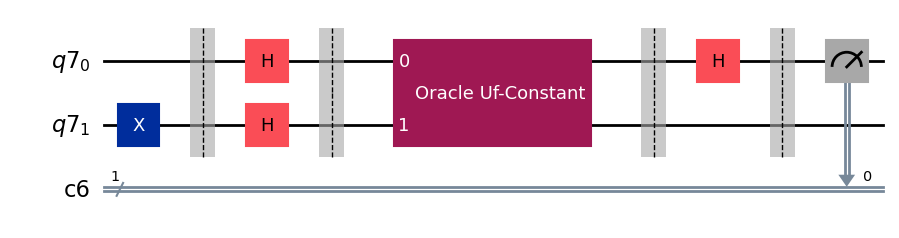

In [45]:
qc.draw("mpl")

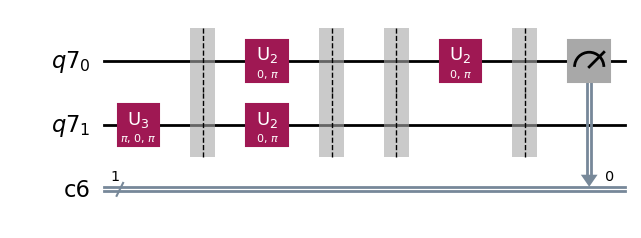

In [46]:
qc.decompose().draw("mpl")

In [47]:
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
#qobj = assemble(compiled_circuit)
results = simulator.run(compiled_circuit, shots=1024).result()
counts = results.get_counts()

In [50]:
#결과 출력
#qc.x(1)의 상태에 따라서
#Constant()는 항상 "0"
#Balanced()는 "0"과 "1" 이 변경됨
print("Measurement results:", counts)

Measurement results: {'0': 1024}


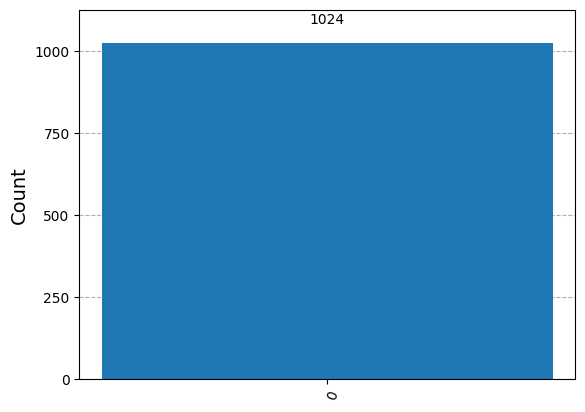

In [51]:
# 결과 히스토그램 출력
plot_histogram(counts)
###def